## THIS IS NEW: 5-fold cross validation on R2 score using random forest regressor

## TAKING A LOT OF COMPUTATION TIME

In [1]:
import os
import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import warnings


warnings.filterwarnings("ignore")
np.random.seed(0)

In [2]:
# Locate the directory in Google Drive
DIRECTORY = 'hopkins_export/'  # Adjust this path to your specific folder in Google Drive
#arr = os.listdir(DIRECTORY)

In [3]:
# the list of columns to be dropped
drop_ls = [
    "expected_time",
    "flip_time",
    "stim_pos",
    "user_pos",
    "lambda_val",
    "change_rate_x",
]


In [4]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

arr = [f for f in os.listdir(DIRECTORY) if f.endswith('.csv')]

scores = []
# Enumerate across all samples
for i, subject_ in enumerate(arr):
    subject = pd.read_csv('hopkins_export/' + subject_)
    #y_pos = subject["stim_pos"].to_numpy()  # stimulus position
    # Prepare X variables and y labels
    X = subject.drop(columns=drop_ls).to_numpy()
    # y_pos_dif = subject["user_pos"].to_numpy() - subject["stim_pos"].to_numpy()

    # SWITCH TO THESE OTHER TWO IF INTERESTED
    # REMEMBER TO CHANGE NAMES
#     y_pos = subject["stim_pos"].to_numpy()  # position
    y_speed = subject["change_rate_x"].to_numpy()  # speed of change

    samples = np.geomspace(1000, len(y_speed), num=3, dtype=int)
    kf = KFold(shuffle=True, random_state=0)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-2, random_state=0)

    score_k_fold_samples = []

    # 5-fold cross validation
    for sample in samples:
        sample_index = np.random.choice(len(y_speed), sample, replace=False)
        X_sample = X[sample_index]
        y_sample = y_speed[sample_index]

        score_k_fold = []
        for j, (train_index, test_index) in enumerate(kf.split(X_sample)):
            rf.fit(X_sample[train_index], y_sample[train_index])
            score_k_fold.append(
                r2_score(rf.predict(X_sample[test_index]), y_sample[test_index])
            )
        score_k_fold_samples.append(score_k_fold)

    scores.append(score_k_fold_samples)
    with open("original_regression_speed_scores.pkl", "wb") as f:
        pickle.dump(scores, f)

# Save scores to a CSV file
scores_df = pd.DataFrame(scores)
scores_df.to_csv("y_speed_r2_scores_0.csv", index=False)

KeyboardInterrupt: 

## Here is how to generate the plot

In [84]:
import matplotlib.pyplot as plt

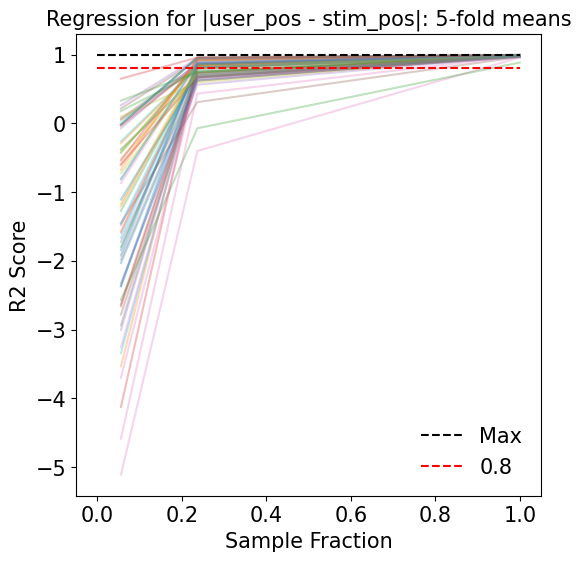

In [102]:
sample_fractions = samples / len(y_speed) # using last sample as reference

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=15)

# plot average R2 scores
for i, score in enumerate(scores):
    ax.plot(sample_fractions, np.mean(score, axis=1), alpha=0.3)

# horizontal grid lines
ax.hlines(1, 0, 1, linestyle="--", color="black", label="Max")
ax.hlines(0.8, 0, 1, linestyle="--", color="red", label="0.8")

ax.set_xlabel("Sample Fraction", fontsize=15)
ax.set_ylabel("R2 Score", fontsize=15)
ax.legend(frameon=False, fontsize=15, loc=4)
plt.title("Regression for |change_rate_x|: 5-fold means (RS=0)", fontsize=15)
plt.show()

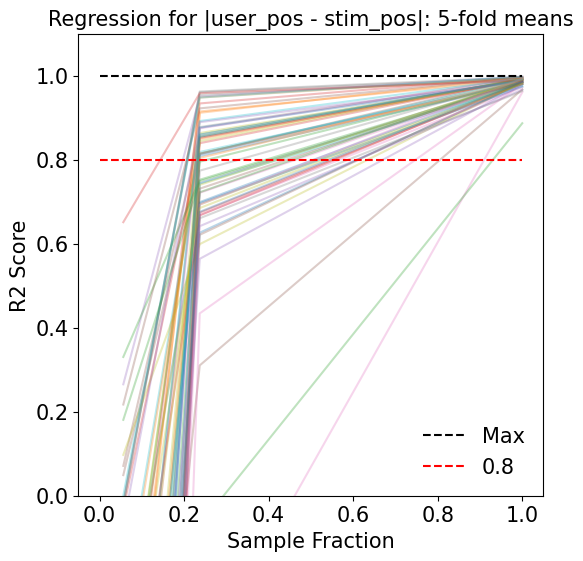

In [103]:
sample_fractions = samples / len(y_speed) # using last sample as reference

fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=15)

# plot average R2 scores
for i, score in enumerate(scores):
    meanR = np.mean(score,axis=1)
    meanR= np.maximum(meanR,0)
    ax.plot(sample_fractions, np.mean(score, axis=1), alpha=0.3)

# horizontal grid lines
ax.hlines(1, 0, 1, linestyle="--", color="black", label="Max")
ax.hlines(0.8, 0, 1, linestyle="--", color="red", label="0.8")

ax.set_xlabel("Sample Fraction", fontsize=15)
ax.set_ylabel("R2 Score", fontsize=15)
ax.legend(frameon=False, fontsize=15, loc=4)
ax.set_ylim(0,1.1)
plt.title("Regression for |change_rate_x|: 5-fold means truncated (RS=0)", fontsize=15)
plt.show()